'''

Predictive Patient Re-admission Model

Date: 17/03/18

Author: Annye Braca

Email: annyebraca@gmail.com

'''

In [90]:

output_notebook()

Loading BokehJS ...

In [160]:
# Importing Libraries
from __future__ import absolute_import, division, print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
from scipy.stats import spearmanr
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import model_selection
#import statsmodels.api as sm
import  sys
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import  linear_model
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
import keras
from keras.layers import Flatten, Conv1D, Dense, GlobalAvgPool1D, GlobalMaxPool1D, Dropout, MaxPool1D, BatchNormalization

Populating the interactive namespace from numpy and matplotlib


C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figure', 'show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [163]:
def one_hot_dataframe(data, cols, replace=False):
    """Create one-hot encodings."""
    vec = feature_extraction.DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    vecData = pd.DataFrame(vec.fit_transform(data[cols].apply(mkdict, axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    if replace:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)
    return (data, vecData)

In [171]:
# Read in data
data = pd.read_csv('../static/diabetic_data.csv')
discharge = pd.ExcelFile('../static/discharge.xlsx')
discharge = discharge.parse('Data')
admission = pd.ExcelFile('../static/admission.xlsx')
admission = admission.parse('Data')
admission_type = pd.ExcelFile('../static/admission_type_ID.xlsx')
admission_type = admission_type.parse('Data')

# Map discharge and admission id descriptions
discharge_map = dict(zip(discharge['discharge_disposition_id'], discharge['description']))
data['discharge_description'] = data['discharge_disposition_id'].map(discharge_map)
admission_map = dict(zip(admission['admission_source_id'], admission['description']))
data['admission_description'] = data['admission_source_id'].map(admission_map)
# bring in admission type id
admission_type_map = dict(zip(admission_type['admission_type_id'], admission['description']))
data['admission_type_description'] = data['admission_type_id'].map(admission_type_map)
# Drop original ids as these are not dropped in one-hot_encoding function
data.drop(['discharge_disposition_id', 'admission_source_id', 'admission_type_id'], axis=1, inplace=True)

# Mapping Age
age_ranges = list(set(data['age']))#
age_ordinal = [1, 8, 7, 6, 0, 9, 4, 2, 5, 3]
age_map = dict(zip(age_ranges, age_ordinal))
data['age'] = data['age'].map(age_map)


data.replace('?' , np.nan, inplace=True)
data.drop(['weight', 'medical_specialty', 'payer_code', 'diag_2', 'diag_3',  'patient_nbr', 'encounter_id'], axis=1, inplace=True)

data = data[~(data['diag_1'].str.startswith('V') | (data['diag_1'].str.startswith('E')))]


data.dropna(inplace=True)

data, med = one_hot_dataframe(data, ["admission_description",
                                     "discharge_description",
                                     "admission_type_description",
                                     "race",
                                     "gender",
                                     "metformin",
                                     "repaglinide",
                                     "nateglinide",
                                     "chlorpropamide",
                                     "glimepiride",
                                     "acetohexamide",
                                     "glipizide",
                                     "glyburide",
                                     "tolbutamide",
                                     "pioglitazone",
                                     "rosiglitazone",
                                     "acarbose",
                                     "miglitol",
                                     "troglitazone",
                                     "tolazamide",
                                     "examide",
                                     "citoglipton",
                                     "insulin",
                                     "glyburide-metformin",
                                     "glipizide-metformin",
                                     "glimepiride-pioglitazone",
                                     "metformin-rosiglitazone",
                                     "metformin-pioglitazone",
                                     'A1Cresult',
                                     'max_glu_serum',
                                     'change',
                                     'diabetesMed'], replace=True)


#set(data['readmitted'])
data = data[data['diabetesMed=Yes'] == 1]
print ('Diabetes patients: {}'.format(len(data)))
print ('Readmitted: No: {}'.format(len(data[data['readmitted'] == 'NO'])))
print ('Readmitted: <30: {}'.format(len(data[data['readmitted'] == '<30'])))
print ('Readmitted: >30: {}'.format(len(data[data['readmitted'] == '>30'])))

Diabetes patients: 67970
Readmitted: No: 35172
Readmitted: <30: 7888
Readmitted: >30: 24910


In [172]:
inds = pd.isnull(data).any(1).nonzero()[0]
data.ix[inds]

C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,number_diagnoses,...,rosiglitazone=Down,rosiglitazone=No,rosiglitazone=Steady,rosiglitazone=Up,tolazamide=No,tolazamide=Steady,tolbutamide=No,tolbutamide=Steady,troglitazone=No,troglitazone=Steady


In [91]:
#output_file("bar_colormapped.html")

patients = ['No-Readmitted','Readmited <30','Readmited >30']
counts = [10,7,2]
source = ColumnDataSource(data=dict(patients=patients, counts=counts))

p = figure(x_range=patients, plot_height=350, toolbar_location=None, title="Patients Counts")
p.vbar(x='patients', top='counts', width=0.9, source=source, legend="patients",
       line_color='white', fill_color=factor_cmap('patients', palette=Spectral6, factors=patients))

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.y_range.end = 9
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

Binary Mapping

In [173]:
#mapping readmitted
readmitted_ranges = list(set(data['readmitted']))
readmitted_ordinal = [1, 0, 1]
readmitted_map = dict(zip(readmitted_ranges, readmitted_ordinal))
data['readmitted'] = data['readmitted'].map(readmitted_map)

In [174]:
###########Subsetting data  , we are interested just in people with a Diabetes condition  #################

In [175]:
diabetes = data[data['diabetesMed=Yes'] == 1]

In [176]:
readmitted_map

{'<30': 1, '>30': 1, 'NO': 0}

In [177]:
X = diabetes
inds = pd.isnull(X).any(1).nonzero()[0]
y = diabetes['readmitted']
X.drop(['readmitted', 'readmitted'], axis=1, inplace=True)

In [178]:
# Separate training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=50)

In [24]:
###############Convolutional neural networks####################

In [25]:
from keras.regularizers import L1L2

In [26]:
def create_baseline(input_nodes,
                    hidden1_nodes,
                    hidden2_nodes,
                    hidden3_nodes,
                    output_nodes,
                    dropout_rate):
        # NN architecturE
        model = Sequential()
        #model.add(GlobalAvgPool1D(input_shape=(146,2,)))
        model.add(Dense(output_dim=hidden1_nodes,
                        input_dim=input_nodes,
                        activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim=hidden2_nodes,
                        input_dim=hidden1_nodes,
                        activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim=hidden3_nodes,
                        input_dim=hidden2_nodes,
                        activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim=hidden4_nodes,
                        input_dim=hidden3_nodes,
                        activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim=output_nodes,
                        input_dim=hidden4_nodes,
                        activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model

In [27]:
# categorical_crossentrophy expects targets to be binary matrices - if target are integer classes
# we need to convert to the expected format using to categorical
# fix random seed for reproducibility
y_train = np.array(y_train)
y_train = [[x] for x in y_train]
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test = [[x] for x in y_test]
y_test = np.array(y_test)

In [31]:
""" Keras Sequential model with Manual validation
"""
start_time = time.time()


# Only for categorical_crossentrophy - Comment out for binary_crossentrophy
#y_train = keras.utils.to_categorical(y_train, num_classes=3)
#y_test = keras.utils.to_categorical(y_test, num_classes=3)

seed = 13
np.random.seed(seed)
cvscores = []
learning_rate = 0.02
sgd = SGD(lr=learning_rate, momentum=0.05, nesterov=False)

input_nodes = 146
hidden1_nodes = 50
hidden2_nodes = 50
hidden3_nodes = 50
hidden4_nodes = 50
output_nodes = 1
dropout_rate = 0.1


model = create_baseline(input_nodes,
                        hidden1_nodes,
                        hidden2_nodes,
                        hidden3_nodes,
                        output_nodes,
                        dropout_rate)



model.fit(X_train, y_train, epochs=50, batch_size=120) 
print('--- %s seconds ---'%(time.time() - start_time))
'''
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=model,
                            nb_epoch=100,
                            batch_size=200,
                            verbose=2)
kfold = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=seed)
results = cross_val_score(estimator,
                          X,
                          y,
                          cv=kfold)
'''
#print("Results of 10-fold Cross-Validation: %.2f%% (%.2f%%)" % (results.mean() * 100, results.std() * 100))

C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=50, activation="relu", input_dim=146)`
C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=50, activation="relu", input_dim=50)`
C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=50, activation="relu", input_dim=50)`
C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=50, activation="relu", input_dim=50)`
C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="sigmoid", input_dim=50)`


Epoch 1/50
47579/47579 [==============================] - 6s 126us/step - loss: 0.0404 - acc: 0.9953
Epoch 2/50
47579/47579 [==============================] - 6s 122us/step - loss: 4.1220e-06 - acc: 1.0000
Epoch 3/50
47579/47579 [==============================] - 6s 124us/step - loss: 2.7303e-07 - acc: 1.0000
Epoch 4/50
47579/47579 [==============================] - 6s 124us/step - loss: 6.2318e-06 - acc: 1.0000
Epoch 5/50
47579/47579 [==============================] - 6s 132us/step - loss: 1.4746e-07 - acc: 1.0000
Epoch 6/50
47579/47579 [==============================] - 6s 136us/step - loss: 1.4570e-07 - acc: 1.0000
Epoch 7/50
47579/47579 [==============================] - 6s 134us/step - loss: 1.4141e-07 - acc: 1.0000
Epoch 8/50
47579/47579 [==============================] - 7s 140us/step - loss: 1.1946e-07 - acc: 1.0000 0s - loss: 1.1946e-07 - acc: 1.0
Epoch 9/50
47579/47579 [==============================] - 6s 132us/step - loss: 1.2186e-07 - acc: 1.0000
Epoch 10/50
47579/47579 [=

'\n# evaluate model with standardized dataset\nestimator = KerasClassifier(build_fn=model,\n                            nb_epoch=100,\n                            batch_size=200,\n                            verbose=2)\nkfold = StratifiedKFold(n_splits=10,\n                        shuffle=True,\n                        random_state=seed)\nresults = cross_val_score(estimator,\n                          X,\n                          y,\n                          cv=kfold)\n'

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [74]:

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.883


In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     18036
          1       0.51      0.02      0.04      2355

avg / total       0.84      0.88      0.83     20391



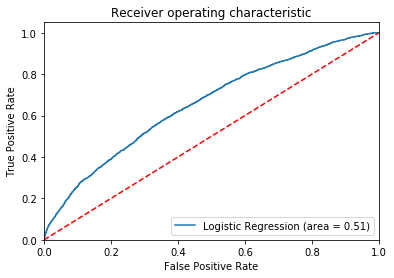

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [68]:
# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=10)
# 2) svm
clf = svm.SVC(kernel='linear')

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)
y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94     18036
          1       0.00      0.00      0.00      2355

avg / total       0.78      0.88      0.83     20391



C:\Users\Creative\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
